In [1]:
# =========================
# FULL MANUAL TRAINING NOTEBOOK (Colab-ready)
# =========================

# === Step 0: Install (run once) ===
!pip install -q transformers torch torchvision timm tqdm

# === Step 1: Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Step 2: Imports & Config ===
import os, random, time, io
from collections import defaultdict
from copy import deepcopy
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from transformers import ViTForImageClassification, ViTImageProcessor

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Paths (update if different)
BASE_DRIVE_PATH = "/content/drive/MyDrive/balanced_dataset"
TRAIN_DIR = os.path.join(BASE_DRIVE_PATH, "training_set")
TEST_DIR  = os.path.join(BASE_DRIVE_PATH, "test_set")
SAVE_DIR  = os.path.join("/content/drive/MyDrive", "vit_personality_finetuned_manual")
os.makedirs(SAVE_DIR, exist_ok=True)

print("Train dir:", TRAIN_DIR)
print("Test dir: ", TEST_DIR)
print("Save dir: ", SAVE_DIR)

# === Step 3: Inspect dataset and counts (sanity) ===
def inspect_and_count(root_dir):
    counts = defaultdict(int)
    invalids = []
    if not os.path.isdir(root_dir):
        raise FileNotFoundError(f"{root_dir} not found.")
    for cls in sorted(os.listdir(root_dir)):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        for fname in os.listdir(cls_path):
            fpath = os.path.join(cls_path, fname)
            if not os.path.isfile(fpath): continue
            try:
                with Image.open(fpath) as im:
                    im.verify()
                counts[cls] += 1
            except Exception:
                invalids.append(fpath)
    return counts, invalids

train_counts, train_invalids = inspect_and_count(TRAIN_DIR)
test_counts, test_invalids = inspect_and_count(TEST_DIR)

print("\nTraining counts:")
for k,v in train_counts.items(): print(f" - {k}: {v}")
print("Invalid in train:", len(train_invalids))

print("\nTest counts:")
for k,v in test_counts.items(): print(f" - {k}: {v}")
print("Invalid in test:", len(test_invalids))

if len(train_counts) < 2:
    raise RuntimeError("Need >= 2 classes in training set.")

# === Step 4: Data transforms and DataLoaders ===
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")  # safe default processor for normalization
mean = processor.image_mean
std  = processor.image_std

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(3),
    transforms.RandomHorizontalFlip(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(TEST_DIR, transform=val_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataset sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}")
print("Classes:", train_dataset.classes)
num_classes = len(train_dataset.classes)

# === Step 5: Load ViT model & optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# === Step 6: Training loop (manual, with early stopping) ===
epochs = 8
best_val_loss = float('inf')
best_state = None
patience = 3
no_improve = 0
global_step = 0

for epoch in range(1, epochs+1):
    model.train()
    running_train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]")
    for imgs, labels in train_bar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=imgs)  # ViT expects pixel_values keyword or positional pixel_values
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        global_step += 1
        train_bar.set_postfix(loss=f"{running_train_loss/(train_bar.n+1):.4f}")

    avg_train_loss = running_train_loss / len(train_loader)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [val]"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=imgs)
            logits = outputs.logits
            loss = criterion(logits, labels)
            running_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = 100.0 * correct / total if total>0 else 0.0

    print(f"\nEpoch {epoch} summary -> TrainLoss: {avg_train_loss:.4f}  ValLoss: {avg_val_loss:.4f}  ValAcc: {val_acc:.2f}%")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping & checkpoint
    if avg_val_loss < best_val_loss - 1e-6:
        best_val_loss = avg_val_loss
        best_state = deepcopy(model.state_dict())
        no_improve = 0
        # save checkpoint to Drive
        ckpt_dir = os.path.join(SAVE_DIR, "best_model")
        os.makedirs(ckpt_dir, exist_ok=True)
        model.save_pretrained(ckpt_dir)
        processor.save_pretrained(ckpt_dir)
        print(f"✅ Saved new best model (val_loss: {best_val_loss:.4f}) -> {ckpt_dir}")
    else:
        no_improve += 1
        print(f"⏳ No improvement counter: {no_improve}/{patience}")
        if no_improve >= patience:
            print("🛑 Early stopping triggered.")
            break

# after training: restore best
if best_state is not None:
    model.load_state_dict(best_state)
    final_dir = os.path.join(SAVE_DIR, "final_best_model")
    os.makedirs(final_dir, exist_ok=True)
    model.save_pretrained(final_dir)
    processor.save_pretrained(final_dir)
    print(f"\n✅ Final best model saved at: {final_dir}")
else:
    print("\n⚠️ No improvement during training; last epoch model saved.")
    fallback = os.path.join(SAVE_DIR, "last_epoch_model")
    model.save_pretrained(fallback)
    processor.save_pretrained(fallback)
    print("Saved fallback model at:", fallback)

# === Step 7: Prediction helper (two-stage: heuristic handwriting detector -> ViT) ===
# Handwriting heuristic detector using ink+edge density
def is_handwritten_pil(pil_img, resize=(224,224), ink_low=0.003, ink_high=0.33, edge_min=0.015):
    img = pil_img.convert("L").resize(resize)
    arr = np.array(img).astype(np.uint8)
    total = arr.size
    ink_mask = arr < 200
    ink_ratio = float(np.count_nonzero(ink_mask)) / total
    edges = img.filter(ImageFilter.FIND_EDGES)
    edges_arr = np.array(edges).astype(np.uint8)
    edge_mask = edges_arr > 40
    edge_ratio = float(np.count_nonzero(edge_mask)) / total
    is_hand = (ink_ratio >= ink_low) and (ink_ratio <= ink_high) and (edge_ratio >= edge_min)
    diag = {"ink_ratio": ink_ratio, "edge_ratio": edge_ratio}
    return bool(is_hand), diag

def predict_image_local(image_path, model, processor, classes):
    img = Image.open(image_path).convert("RGB")
    # handwriting check
    hand, diag = is_handwritten_pil(img)
    if not hand:
        return {"ok": False, "message": "Please upload a valid & handwritten image.", "diag": diag}
    # preprocess and predict
    inputs = processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k,v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze(0).cpu().numpy()
    top_idx = int(np.argmax(probs))
    return {"ok": True, "pred_label": classes[top_idx], "probs": probs, "diag": diag}

# Example: upload one local image in Colab and predict
from google.colab import files
print("\n▶ Upload a sample image (handwritten) to test prediction.")
uploaded = files.upload()
if len(uploaded) > 0:
    img_path = list(uploaded.keys())[0]
    res = predict_image_local(img_path, model, processor, train_dataset.classes)
    print("\nDiagnostics:", res["diag"])
    if not res["ok"]:
        print("⚠️", res["message"])
    else:
        print("🔮 Predicted:", res["pred_label"])
        # show bar chart of probabilities
        probs = res["probs"]
        plt.figure(figsize=(8,3))
        bars = plt.bar(train_dataset.classes, probs)
        plt.ylim(0,1)
        for b,p in zip(bars, probs):
            plt.text(b.get_x()+b.get_width()/2, p+0.01, f"{p:.2f}", ha='center')
        plt.title(f"Pred: {res['pred_label']}")
        plt.show()

print("\nNotebook finished. Model saved to Drive.")

Mounted at /content/drive
Train dir: /content/drive/MyDrive/balanced_dataset/training_set
Test dir:  /content/drive/MyDrive/balanced_dataset/test_set
Save dir:  /content/drive/MyDrive/vit_personality_finetuned_manual

Training counts:
 - Agreeableness: 40
 - Conscientiousness: 40
 - Extraversion: 40
 - Neuroticism: 40
 - Openness: 40
Invalid in train: 0

Test counts:
 - Agreeableness: 10
 - Conscientiousness: 10
 - Extraversion: 10
 - Neuroticism: 10
 - Openness: 10
Invalid in test: 0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]


Dataset sizes -> train: 200, val: 50
Classes: ['Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']
Using device: cuda


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1 summary -> TrainLoss: 1.5429  ValLoss: 1.4142  ValAcc: 62.00%
✅ Saved new best model (val_loss: 1.4142) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 2/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2 summary -> TrainLoss: 1.2922  ValLoss: 1.2330  ValAcc: 80.00%
✅ Saved new best model (val_loss: 1.2330) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 3/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3 summary -> TrainLoss: 1.1117  ValLoss: 1.0678  ValAcc: 88.00%
✅ Saved new best model (val_loss: 1.0678) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 4/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4 summary -> TrainLoss: 0.9647  ValLoss: 0.9916  ValAcc: 90.00%
✅ Saved new best model (val_loss: 0.9916) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 5/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5 summary -> TrainLoss: 0.8282  ValLoss: 0.8370  ValAcc: 90.00%
✅ Saved new best model (val_loss: 0.8370) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 6/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 6 summary -> TrainLoss: 0.7194  ValLoss: 0.7357  ValAcc: 94.00%
✅ Saved new best model (val_loss: 0.7357) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 7/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 7 summary -> TrainLoss: 0.6117  ValLoss: 0.6342  ValAcc: 96.00%
✅ Saved new best model (val_loss: 0.6342) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model


Epoch 8/8 [train]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/8 [val]:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 8 summary -> TrainLoss: 0.5143  ValLoss: 0.5660  ValAcc: 92.00%
✅ Saved new best model (val_loss: 0.5660) -> /content/drive/MyDrive/vit_personality_finetuned_manual/best_model

✅ Final best model saved at: /content/drive/MyDrive/vit_personality_finetuned_manual/final_best_model

▶ Upload a sample image (handwritten) to test prediction.


Saving 1000458442.jpg to 1000458442.jpg

Diagnostics: {'ink_ratio': 0.8671077806122449, 'edge_ratio': 0.10367506377551021}
⚠️ Please upload a valid & handwritten image.

Notebook finished. Model saved to Drive.


✅ Model loaded successfully.
Using device: cuda

▶ Upload an image for prediction:


Saving IMG_20200215_172554.jpg to IMG_20200215_172554.jpg


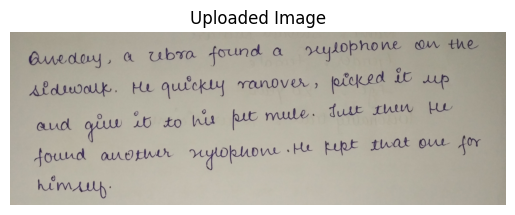


🧩 Prediction Results
-------------------------
Agreeableness     : 4.39%
Conscientiousness : 12.52%
Extraversion      : 6.90%
Neuroticism       : 61.33%
Openness          : 14.86%

✅ Predicted Personality Trait:
👉 Neuroticism (61.33% confidence)


In [9]:
# ==========================
# 🧠 Personality Prediction Script
# ==========================

from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch
from google.colab import files
import matplotlib.pyplot as plt

# ==========================
# 1️⃣  Paths & Setup
# ==========================
model_path = "/content/drive/MyDrive/vit_personality_finetuned_manual/final_best_model"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model + image processor
model = ViTForImageClassification.from_pretrained(model_path).to(device)
processor = ViTImageProcessor.from_pretrained(model_path)

# Define your class names (order must match your training labels)
class_names = ["Agreeableness", "Conscientiousness", "Extraversion", "Neuroticism", "Openness"]

print("✅ Model loaded successfully.")
print(f"Using device: {device}")

# ==========================
# 2️⃣  Upload an image
# ==========================
print("\n▶ Upload an image for prediction:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load and show the image
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

# ==========================
# 3️⃣  Preprocess & Predict
# ==========================
inputs = processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_idx = probs.argmax(-1).item()
    confidence = probs[0][pred_idx].item()

pred_label = class_names[pred_idx]

# ==========================
# 4️⃣  Display Results
# ==========================
print("\n🧩 Prediction Results")
print("-------------------------")
for i, label in enumerate(class_names):
    print(f"{label:18s}: {probs[0][i]*100:.2f}%")

print("\n✅ Predicted Personality Trait:")
print(f"👉 {pred_label} ({confidence*100:.2f}% confidence)")

In [8]:
# ============================
# 🧠 UPDATED HANDWRITING DETECTOR + PREDICTION
# ============================

from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import torch

def is_handwritten_pil(pil_img, resize=(224,224), ink_low=0.002, ink_high=0.98, edge_min=0.005):
    img = pil_img.convert("L").resize(resize)
    arr = np.array(img).astype(np.uint8)

    # Dynamically find threshold based on brightness histogram
    mean_brightness = np.mean(arr)
    adaptive_threshold = max(180, min(245, mean_brightness + 20))  # between 180–245 range

    total = arr.size
    ink_mask = arr < adaptive_threshold
    ink_ratio = float(np.count_nonzero(ink_mask)) / total

    edges = img.filter(ImageFilter.FIND_EDGES)
    edges_arr = np.array(edges).astype(np.uint8)
    edge_mask = edges_arr > 20
    edge_ratio = float(np.count_nonzero(edge_mask)) / total

    is_hand = (ink_ratio >= ink_low) and (ink_ratio <= ink_high) and (edge_ratio >= edge_min)
    diag = {
        "ink_ratio": round(ink_ratio, 3),
        "edge_ratio": round(edge_ratio, 3),
        "adaptive_threshold": adaptive_threshold,
        "mean_brightness": round(mean_brightness, 1)
    }
    return bool(is_hand), diag


# --- Prediction helper ---
def predict_image_local(image_path, model, processor, classes):
    img = Image.open(image_path).convert("RGB")

    # Handwriting check
    hand, diag = is_handwritten_pil(img)
    if not hand:
        return {"ok": False, "message": "Please upload a valid handwritten image.", "diag": diag}

    # Preprocess and predict
    inputs = processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze(0).cpu().numpy()

    top_idx = int(np.argmax(probs))
    return {"ok": True, "pred_label": classes[top_idx], "probs": probs, "diag": diag}


# --- Upload and predict ---
from google.colab import files
print("\n▶ Upload a sample handwritten image to test prediction.")
uploaded = files.upload()

if len(uploaded) > 0:
    img_path = list(uploaded.keys())[0]
    res = predict_image_local(img_path, model, processor, train_dataset.classes)
    print("\nDiagnostics:", res["diag"])

    if not res["ok"]:
        print("⚠️", res["message"])
    else:
        print(f"🔮 Predicted Personality Trait: {res['pred_label']}")

        # --- Probability bar chart ---
        probs = res["probs"]
        plt.figure(figsize=(8,3))
        bars = plt.bar(train_dataset.classes, probs, color='skyblue', edgecolor='black')
        plt.ylim(0, 1)
        for b, p in zip(bars, probs):
            plt.text(b.get_x() + b.get_width()/2, p + 0.02, f"{p:.2f}", ha='center')
        plt.title(f"Prediction Result: {res['pred_label']}")
        plt.xlabel("Personality Trait")
        plt.ylabel("Probability")
        plt.show()


▶ Upload a sample handwritten image to test prediction.


Saving IMG_20200215_172420.jpg to IMG_20200215_172420.jpg

Diagnostics: {'ink_ratio': 0.993, 'edge_ratio': 0.121, 'adaptive_threshold': np.float64(182.79675542091837), 'mean_brightness': np.float64(162.8)}
⚠️ Please upload a valid handwritten image.


In [6]:
img_path = "/content/IMG_20200215_181912.jpg"  # or the uploaded file name
res = predict_image_local(img_path, model, processor, train_dataset.classes)
print("\nDiagnostics:", res["diag"])
if not res["ok"]:
    print("⚠️", res["message"])
else:
    print("🔮 Predicted Personality Trait:", res["pred_label"])


Diagnostics: {'ink_ratio': 0.961, 'edge_ratio': 0.124, 'adaptive_threshold': 180, 'mean_brightness': np.float64(157.7)}
🔮 Predicted Personality Trait: Openness
